In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils import get_dfs, extract_classes
figure(figsize=(20, 10), dpi=80)
import operator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

<Figure size 1600x800 with 0 Axes>

In [2]:
hdf_file_path = "../data/20221029-171117.hdf5"
(df_raw, df_events, df_filtered, df_bands) = get_dfs(hdf_file_path)

In [4]:
def prepare_ts_for_kmeans(ts_df, event_df):
    df_lag = ts_df.copy()
    for i in range(1, 50):
        df_lag = df_lag.merge(ts_df.shift(i), how='inner', left_index=True, right_index=True, suffixes=('',f'_{i:02d}'))
    ts_df = df_lag.dropna().copy()
    del df_lag
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    X = None

    for c in range(len(classes)):
        start_events = event_df.loc[(event_df.data == classes[c])]
        ref_start_date = start_events.index[0]
        start = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'start')].index[0]
        end = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'stop')].index

        if len(end) == 0:
            end = ts_df.index[-1]
        else:
            end = end[0]

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])

        res = ts_df[start:end].head(500).values
        # print(np.array(res).shape)
        if X is None:
            X = res
        else:
            X = np.concatenate((X, res), axis=0)
    return X

In [5]:
# wid = 30

# df_lag = datasets_dic['bands'].copy()
# for i in range(1,wid):
#     df_lag = df_lag.merge(datasets_dic['bands'].shift(i), how='inner', left_index=True, right_index=True, suffixes=('',f'_{i:02d}'))

X = prepare_ts_for_kmeans(df_raw, df_events)
# print(X.shape)
X.shape
X = X.reshape(-1, 50, 1)
X.shape
# display(X[0])

(11500, 50, 1)

In [6]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
# model.fit(X)
y_pred = model.fit_predict(X)    

In [8]:
plt.figure(figsize=(16, 9))
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X[y_pred == yi]:
        plt.plot(X[y_pred == yi].ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    # plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.tight_layout()
plt.show()

: 

: 

In [187]:
def split_df_by_event(ts_df, event_df):
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    result = {}
    for c in range(len(classes)):
        if classes[c] not in result:
            result[classes[c]] = []
        start_events = event_df.loc[(event_df.data == classes[c])]
        ref_start_date = start_events.index[0]
        start = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'start')].index[0]
        end = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'stop')].index

        if len(end) == 0:
            # Get the row after ref_start_date
            end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
        else:
            end = end[0]

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
        result[classes[c]].append(ts_df[start:end])
    return result

def get_X(dict_arr):
    X = []
    Y = []
    for key in dict_arr.keys():
        tmp_res = []
        for elmt in dict_arr[key]:
            tmp_res = np.concatenate((tmp_res, elmt.head(500)['Fpz'].values), axis=0)
        X = np.concatenate((X, tmp_res))
        # Append 500 key in Y
        Y = np.concatenate((Y, np.full(500, key)), axis=0)
        # print(len(Y))
    classes = extract_classes(df_events)
    classes = np.array(classes)
    classes = np.unique(classes)
    X = X.reshape(len(classes), -1)
    # Y = Y.reshape(-1,)
    return (X, Y, classes)



/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_20210/1972069893.py:15: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


"repos"


,Fpz
2022-10-29 17:11:28.120303,-1.696866
2022-10-29 17:11:28.130303,-5.939030
2022-10-29 17:11:28.140303,-0.771303
2022-10-29 17:11:28.150303,-3.625122
2022-10-29 17:11:28.160303,-1.234084
...,...
2022-10-29 17:12:16.780303,-9.101370
2022-10-29 17:12:16.790303,-9.332761
2022-10-29 17:12:16.800303,-12.417971
2022-10-29 17:12:16.810303,-5.707639


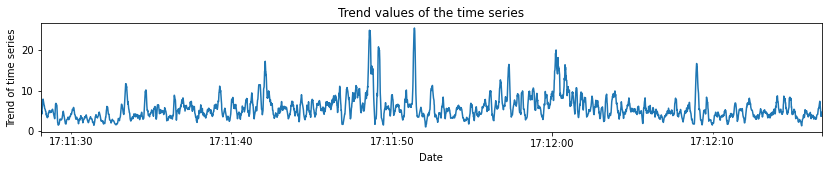

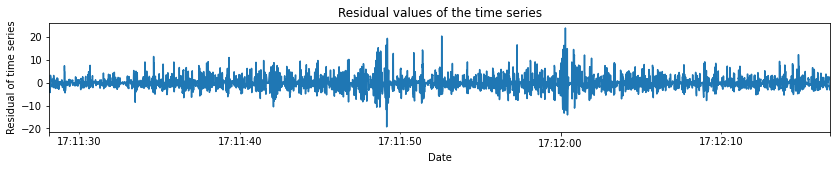

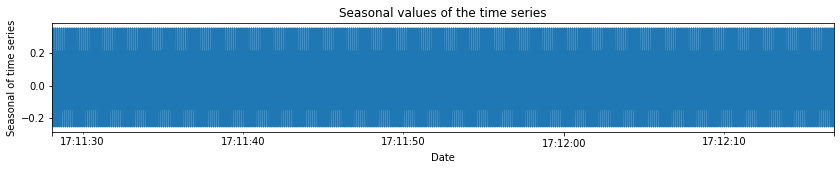

"rapide"


,Fpz
2022-10-29 17:12:16.830303,-10.952496
2022-10-29 17:12:16.840303,0.925563
2022-10-29 17:12:16.850303,-2.699559
2022-10-29 17:12:16.860303,3.856513
2022-10-29 17:12:16.870303,-19.205433
...,...
2022-10-29 17:13:23.810303,0.539912
2022-10-29 17:13:23.820303,-4.396424
2022-10-29 17:13:23.830303,10.181193
2022-10-29 17:13:23.840303,-0.077130


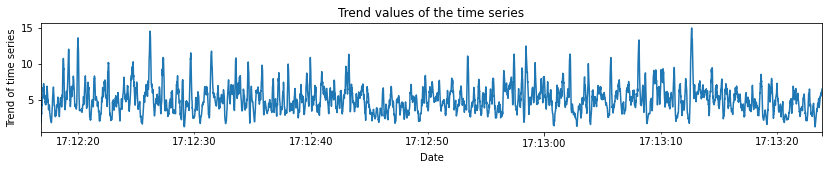

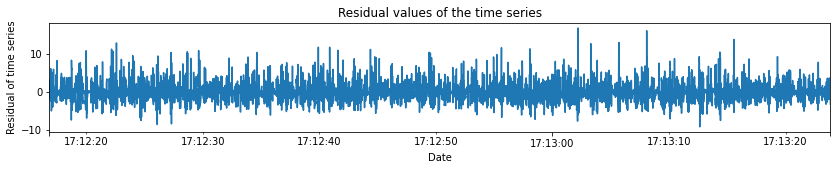

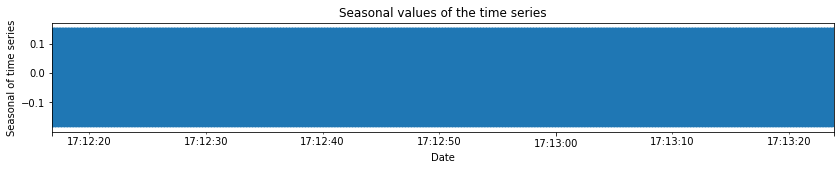

"lent"


,Fpz
2022-10-29 17:14:01.690303,-5.476248
2022-10-29 17:14:01.700303,-2.776689
2022-10-29 17:14:01.710303,-5.090597
2022-10-29 17:14:01.720303,2.005387
2022-10-29 17:14:01.730303,-13.729185
...,...
2022-10-29 17:14:58.400303,-3.470861
2022-10-29 17:14:58.410303,-3.856513
2022-10-29 17:14:58.420303,-1.773996
2022-10-29 17:14:58.430303,9.564151


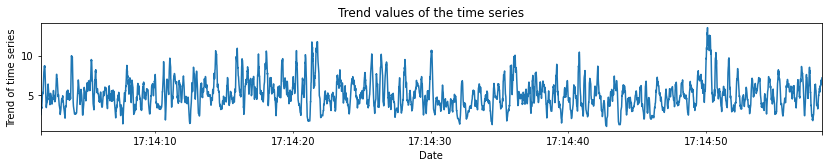

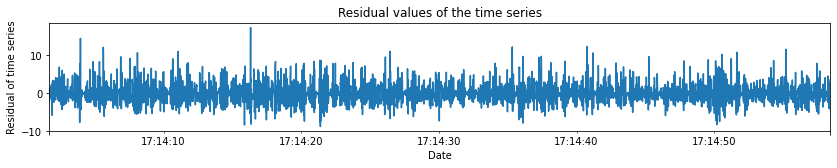

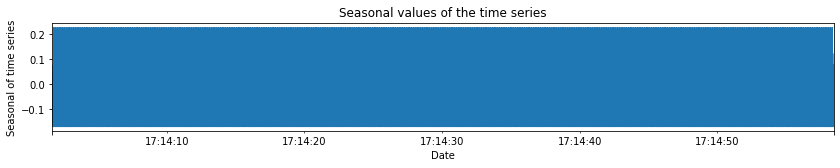

"interuption"


,Fpz
2022-10-29 17:25:23.780303,-4.473555
2022-10-29 17:25:23.790303,0.539912
2022-10-29 17:25:23.800303,2.545298
2022-10-29 17:25:23.810303,1.851126
2022-10-29 17:25:23.820303,-4.782076
...,...
2022-10-29 17:25:51.310303,-3.085210
2022-10-29 17:25:51.320303,9.409891
2022-10-29 17:25:51.330303,1.002693
2022-10-29 17:25:51.340303,-2.699559


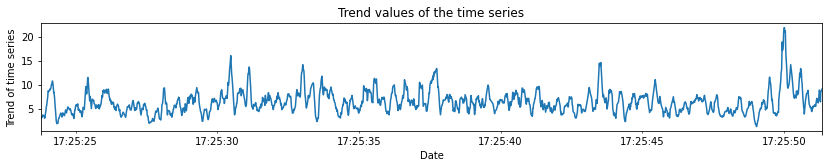

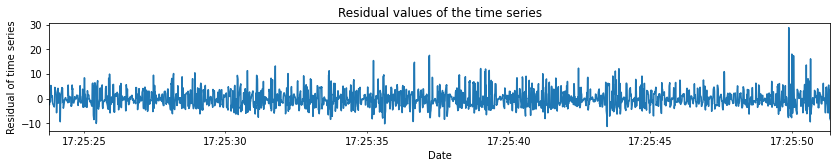

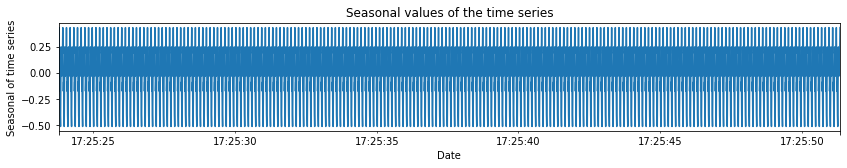

"fin"


,Fpz
2022-10-29 17:27:01.660303,39.027908
2022-10-29 17:27:01.670303,39.027908
2022-10-29 17:27:01.680303,35.171396
2022-10-29 17:27:01.690303,39.027908
2022-10-29 17:27:01.700303,39.027908
...,...
2022-10-29 17:27:23.220303,39.027908
2022-10-29 17:27:23.230303,39.027908
2022-10-29 17:27:23.240303,39.027908
2022-10-29 17:27:23.250303,39.027908


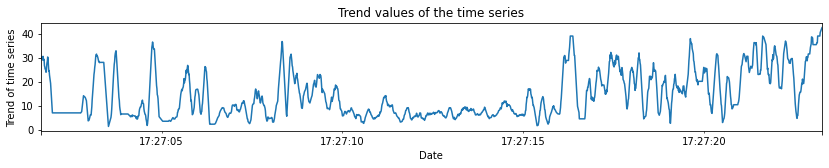

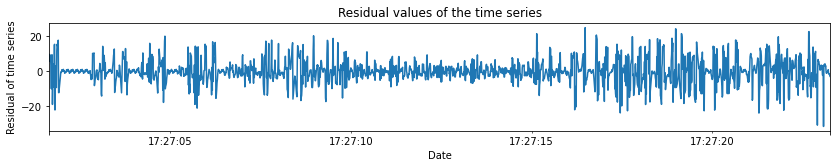

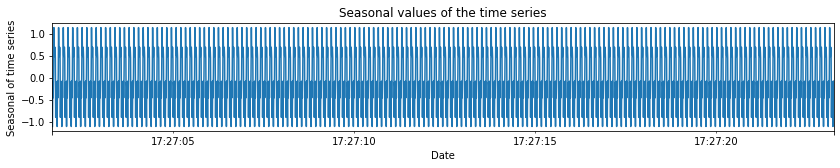

In [217]:
dictionarry = split_df_by_event(df_raw, df_events)

for key in dictionarry.keys():
    # print(key, len(dictionarry[key]))
    print("=====================================")
    print(key)
    print("=====================================")
    tt_tmp = dictionarry[key].copy()
    elmt = tt_tmp[0]
    # sns.kdeplot(data=tips, x="total_bill")
    display(elmt)
    elmt.index = pd.to_datetime(elmt.index).to_period('ms')
    # display(elmt)
    elmt = elmt.mask(elmt.lt(float(1))).ffill().fillna(float(1)).astype('float32')

    decomposition=sm.tsa.seasonal_decompose(x=elmt['Fpz'],model='additive', extrapolate_trend='freq', period=13)

    decomposition_trend=decomposition.trend
    ax= decomposition_trend.plot(figsize=(14,2))
    ax.set_xlabel('Date')
    ax.set_ylabel('Trend of time series')
    ax.set_title('Trend values of the time series')
    plt.show()

    decomposition_residual=decomposition.resid
    ax= decomposition_residual.plot(figsize=(14,2))
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual of time series')
    ax.set_title('Residual values of the time series')
    plt.show()

    # decomposition_seasonal=decomposition.seasonal
    # ax= decomposition_seasonal.plot(figsize=(14,2))
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Seasonal of time series')
    # ax.set_title('Seasonal values of the time series')
    # plt.show()

In [188]:
splited_filtered = split_df_by_event(df_filtered, df_events)
(X, Y, unique_classes) = get_X(splited_filtered)
X.shape
len(Y)
Y.shape

/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_20210/1972069893.py:15: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


(2500,)

In [196]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
X = random_walks(n_ts=50, sz=32, d=1)
X.shape
# X = get_X(splited_filtered)
# X =
# model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
# model.fit(X)

(50, 32, 1)

In [121]:
unique_classes.shape

(5,)

In [189]:
le = preprocessing.LabelEncoder()
le.fit(unique_classes)
le_Y = le.transform(Y)

In [192]:
le_Y

array([4, 4, 4, ..., 0, 0, 0])

In [151]:
le.classes_

array(['"fin"', '"interuption"', '"lent"', '"rapide"', '"repos"'],
      dtype='<U13')

In [193]:
le_Y.shape

(2500,)

In [194]:
X.shape

(5, 2300)

In [163]:
XX, y = np.arange(10).reshape((5, 2)), range(5)
print(XX.shape)
print(len(y))

(5, 2)
5


In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, le_Y, test_size=0.30, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [5, 2500]

In [111]:
model

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [113]:

import numpy
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
print(y_train)
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# numpy.random.shuffle(X_train)
# # Keep only 50 time series
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# # Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
# sz = X_train.shape[1]

# # Euclidean k-means
# print("Euclidean k-means")
# km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
# y_pred = km.fit_predict(X_train)

# plt.figure()
# for yi in range(3):
#     plt.subplot(3, 3, yi + 1)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Euclidean $k$-means")

# # DBA-k-means
# print("DBA k-means")
# dba_km = TimeSeriesKMeans(n_clusters=3,
#                           n_init=2,
#                           metric="dtw",
#                           verbose=True,
#                           max_iter_barycenter=10,
#                           random_state=seed)
# y_pred = dba_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 4 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

# # Soft-DTW-k-means
# print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=3,
#                            metric="softdtw",
#                            metric_params={"gamma": .01},
#                            verbose=True,
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 7 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")

# plt.tight_layout()
# plt.show()

[1 2 4 3 1 4 4 1 1 4 4 4 4 3 4 1 3 2 4 4 4 4 3 2 1 2 4 4 2 4 1 1 4 4 2 1 1
 2 1 1 3 3 3 3 3 1 4 4 4 2 4 3 2 1 4 2 2 2 2 1 3 2 4 3 3 2 2 1 4 4 2 3 2 1
 3 4 1 1 3 3 1 3 1 3 3 3 4 1 2 1 4 4 4 1 3 1 2 4 1 2]
